<a href="https://colab.research.google.com/github/barywhyte/analytics/blob/master/A/B%20testing%20with%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Approach to A/B testing : UDACITY A/B testing.

### Project description:

 Udacity is an online learning system (https://www.udacity.com/). At the time of the experiment, Udacity courses had two options on the course overview page: "start free trial", and "access course materials". If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.

Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message will appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free.

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course. If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

This is Machine Learning approach to A/B testing done to solve the same hypothesis describe above. Link here https://github.com/barywhyte/analytics/blob/master/A_B_Testing_and_Machine_Learning.ipynb

In [0]:
#import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier 
from sklearn.model_selection import cross_val_score
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn   #ignore warnings from sklearn and seaborn

### Load Data from Github

In [0]:
data = pd.ExcelFile("https://github.com/10acad/piq2019/blob/master/data/UdacityABtesting.xlsx?raw=true")
control = pd.read_excel(data, 'Control')
experiment = pd.read_excel(data, 'Experiment')

### Examine Data

In [3]:
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [4]:
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


## Quiz Qustions

**How many days of observation are there in the control and experimental group?**

In [5]:
print("Number of days of observation in Contro set : ", len(control['Date'].unique()))
print("Number of days of observation in Experiment set : ", len(experiment['Date'].unique()))

Number of days of observation in Contro set :  37
Number of days of observation in Experiment set :  37


**How many missing values are there in each of the control and experiments data?**

In [0]:
def missing_data(data):
  missing = data.isnull().sum()
  missing = missing[missing > 0]
  return missing

In [7]:
print("Number of missing values in Control set :\n", missing_data(control))
print()
print("Number of missing values in Experiment set :\n", missing_data(experiment))

Number of missing values in Control set :
 Enrollments    14
Payments       14
dtype: int64

Number of missing values in Experiment set :
 Enrollments    14
Payments       14
dtype: int64


**Combine the control_tbl and experiment_tbl, adding an “experiment_type” column indicating if the data was part of the experiment or not**

In [0]:
control['experiment_type'] = 'control'
experiment['experiment_type'] = 'experiment'

In [9]:
com_data = pd.concat([control, experiment], ignore_index=True, join='inner')
print(com_data.shape)
com_data.head()

(74, 6)


,Date,Pageviews,Clicks,Enrollments,Payments,experiment_type
0,"Sat, Oct 11",7723,687,134.0,70.0,control
1,"Sun, Oct 12",9102,779,147.0,70.0,control
2,"Mon, Oct 13",10511,909,167.0,95.0,control
3,"Tue, Oct 14",9871,836,156.0,105.0,control
4,"Wed, Oct 15",10014,837,163.0,64.0,control


**Add a “row_id” column to help for tracking which rows are selected for training and testing in the modeling section**

In [10]:
com_data['row_id'] = np.arange(len(com_data))
print(com_data.shape)
com_data.head()

(74, 7)


,Date,Pageviews,Clicks,Enrollments,Payments,experiment_type,row_id
0,"Sat, Oct 11",7723,687,134.0,70.0,control,0
1,"Sun, Oct 12",9102,779,147.0,70.0,control,1
2,"Mon, Oct 13",10511,909,167.0,95.0,control,2
3,"Tue, Oct 14",9871,836,156.0,105.0,control,3
4,"Wed, Oct 15",10014,837,163.0,64.0,control,4


**Create a “Day of Week” feature from the “Date” column**

In [11]:
#splitting date column into 'Day of week' and 'month' columns and saving it in df dataframe
df = pd.DataFrame(com_data['Date'].str.split(' ',1).tolist(), columns = ['Day of Week','Month'])  

#drop month column as it is not needed
df.drop('Month', axis = 1, inplace=True)

#create row_id column for df dataframe to match its equivalent in com_data dataframe
df['row_id'] = np.arange(len(df))

#merge com_data and df datframes on row_id
com_data1 = pd.merge(com_data, df, left_on = 'row_id', right_on = 'row_id')

print(com_data1.shape)
com_data1.head()

(74, 8)


,Date,Pageviews,Clicks,Enrollments,Payments,experiment_type,row_id,Day of Week
0,"Sat, Oct 11",7723,687,134.0,70.0,control,0,"Sat,"
1,"Sun, Oct 12",9102,779,147.0,70.0,control,1,"Sun,"
2,"Mon, Oct 13",10511,909,167.0,95.0,control,2,"Mon,"
3,"Tue, Oct 14",9871,836,156.0,105.0,control,3,"Tue,"
4,"Wed, Oct 15",10014,837,163.0,64.0,control,4,"Wed,"


**Drop the “Date” column and the “Payments” column**

In [12]:
com_data1.drop(['Date', 'Payments'], axis = 1, inplace = True)
print(com_data1.shape)
com_data1.head()

(74, 6)


,Pageviews,Clicks,Enrollments,experiment_type,row_id,Day of Week
0,7723,687,134.0,control,0,"Sat,"
1,9102,779,147.0,control,1,"Sun,"
2,10511,909,167.0,control,2,"Mon,"
3,9871,836,156.0,control,3,"Tue,"
4,10014,837,163.0,control,4,"Wed,"


**Handle the missing data (NaN) by removing these rows**

In [13]:
com_data1.dropna(inplace = True)
print(com_data1.shape)
com_data1.isnull().sum()

(46, 6)


Pageviews          0
Clicks             0
Enrollments        0
experiment_type    0
row_id             0
Day of Week        0
dtype: int64

**Shuffle the rows to mix the data up for machine learning**

In [14]:
com_data1 = shuffle(com_data1).reset_index(drop=True)
print(com_data1.shape)
com_data1.head(10)

(46, 6)


,Pageviews,Clicks,Enrollments,experiment_type,row_id,Day of Week
0,9535,759,233.0,control,16,"Mon,"
1,9670,823,138.0,control,5,"Thu,"
2,10660,867,196.0,control,10,"Tue,"
3,9262,727,201.0,experiment,55,"Wed,"
4,8836,693,206.0,control,22,"Sun,"
5,9793,832,140.0,experiment,41,"Wed,"
6,10511,909,167.0,control,2,"Mon,"
7,7664,652,94.0,experiment,44,"Sat,"
8,9655,771,213.0,experiment,53,"Mon,"
9,8460,681,156.0,control,21,"Sat,"


**HeatMap Correlation**

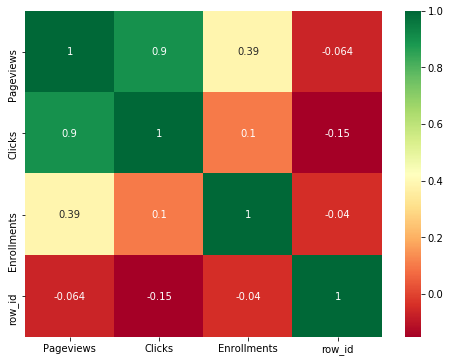

In [15]:
#get correlations of each features in dataset
corrmat = com_data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,6))
#plot heat map
sns.heatmap(com_data1[top_corr_features].corr(),annot=True,cmap="RdYlGn");

                              Pageviews and Clicks have some correlation with Enrollments

In [16]:
com_data1[com_data1.columns[:]].corr()['Enrollments']

Pageviews      0.387528
Clicks         0.102987
Enrollments    1.000000
row_id        -0.040073
Name: Enrollments, dtype: float64

In [17]:
com_data1.describe()

,Pageviews,Clicks,Enrollments,row_id
count,46.000000,46.000000,46.000000,46.000000
mean,9207.065217,751.152174,156.695652,29.500000
std,817.469684,72.921257,32.289571,19.870414
min,7434.000000,632.000000,94.000000,0.000000
25%,8694.000000,693.000000,131.750000,11.250000
50%,9298.000000,735.000000,153.500000,29.500000
75%,9720.250000,817.500000,175.500000,47.750000
max,10667.000000,909.000000,233.000000,59.000000


**Split data into training and target data**

In [0]:
#row_id column is not useful for prediction
X = com_data1.drop(['row_id'], axis = 1) 

In [19]:
X.head()

,Pageviews,Clicks,Enrollments,experiment_type,Day of Week
0,9535,759,233.0,control,"Mon,"
1,9670,823,138.0,control,"Thu,"
2,10660,867,196.0,control,"Tue,"
3,9262,727,201.0,experiment,"Wed,"
4,8836,693,206.0,control,"Sun,"


**Encode the categoical variables with one-hot encoding**

* There are only two categorical variables: **"experiment_type "** and **"Day of Week"**
* The cardinality of each is very small: two and seven respectively.
*  Both categorical variables are nominal variables, so hot-one encoding is prefer to label encoding.

**Get the list of categorical variables**

In [20]:
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
#cat_cols1 = ['Day of Week']
print("Categorical variables:")
print(cat_cols)
#print(cat_cols1)

Categorical variables:
['experiment_type', 'Day of Week']


**Apply one-hot encoder to each column with categorical data**

In [21]:
one_hot = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
one_hot_cols = pd.DataFrame(one_hot.fit_transform(X[cat_cols]))

# One-hot encoding removed index; put it back
one_hot_cols.index = X.index

# Remove categorical columns (will replace with one-hot encoding)
X.drop(cat_cols, axis = 1, inplace = True)
X_train = pd.concat([X, one_hot_cols], axis = 1)
X_train.head()

,Pageviews,Clicks,Enrollments,0,1,2,3,4,5,6,7,8
0,9535,759,233.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9670,823,138.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10660,867,196.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9262,727,201.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8836,693,206.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [0]:
seed = 42
#X_train = shuffle(X_train, random_state=seed)

In [23]:
X_train.head()

,Pageviews,Clicks,Enrollments,0,1,2,3,4,5,6,7,8
0,9535,759,233.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9670,823,138.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10660,867,196.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9262,727,201.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8836,693,206.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**Write a function that return Mean Absolute Error**

In [0]:
def get_score(model, X_train, y_train):
  scores = -1 * cross_val_score(model, X_train, y_train, cv=5)
  print(scores)
  print()
  print("Average MAE score (across experiments) for this model:\n", scores.mean())
  

**Get the MAE for Linear Regression**

In [25]:
get_score(LinearRegression(), X_train.drop(['Enrollments', 'Clicks'], axis = 1), X_train['Enrollments'])

[ 0.47149031  0.69110653 -0.53892287  3.18492087 -0.28189369]

Average MAE score (across experiments) for this model:
 0.7053402310179788


**Get the MAE for Decision Tree Regressor**

In [26]:
get_score(DecisionTreeRegressor(), X_train.drop(['Enrollments', 'Clicks'], axis = 1), X_train['Enrollments'])

[ 0.39639421  1.25912067 -0.40850364  1.70048215  0.55242047]

Average MAE score (across experiments) for this model:
 0.6999827721635812


**Get the MAE for XGBoost Classifer**

In [0]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=X_train.drop(['Enrollments', 'Clicks'], axis = 1), label=X_train['Enrollments'])
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=5,metrics="mae", as_pandas=True, seed=123)

**cv_results contains train and test RMSE metrics for each boosting round.**

In [52]:
cv_results.head()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,141.019198,2.025823,141.070914,9.420555
1,127.449445,1.918201,127.382872,9.792440
2,115.120181,1.819767,115.218497,9.603141
3,103.939212,1.643172,104.037526,9.779716
4,93.846759,1.483737,93.945074,9.939160


**Extract and print the final boosting round metric.**

In [53]:
print((cv_results["test-mae-mean"]).tail(1))

33    24.417876
Name: test-mae-mean, dtype: float64


**Visualize Boosting Trees**

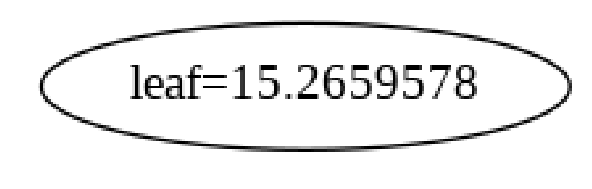

In [54]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

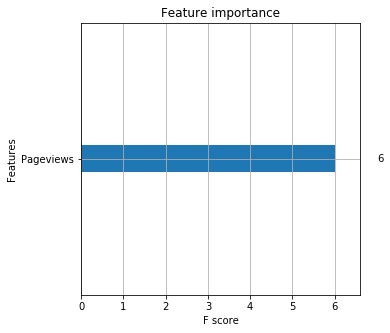

In [60]:
xgb.plot_importance(xg_reg)
#plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

          Pageviews feature is about the most important feature in the XGBoost model.